### References

[1] J.B. Allen and D.A. Berkley, "Image method for efficiently simulating small-room acoustics," Journal Acoustic Society of America, 65(4), April 1979, p 943.

[2]  P. Peterson, "Simulating the response of multiple microphones to a single acoustic source in a reverberant room", Journal of the Acoustical Society of America, vol. 80, no. 5, pp. 1527{1529, Nov. 1986.

In [1]:
import rir_generator as RG
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import wavio
import IPython 

### Define Real Time Processing Context
1. Frame Size
2. Overlap Size

In [2]:
frameSize = 8192
stepSize = 128

### Audio File Needs Pre-Processing Before Making Convolution：
1. Padding Zero
2. Divided into Chunks

In [3]:
def PreProcessData(xn, frameSize, stepSize):
    padding = len(xn) % stepSize
    if(padding == 0):
        temp = xn
    else:
        temp = np.append(xn, np.zeros(stepSize - padding))
    
    data = np.append(np.zeros(frameSize), temp)

    iteration = (len(data) // stepSize) - (frameSize // stepSize) + 1
    
    dataSet = np.zeros([iteration, frameSize])
    
    for i in range(iteration):
        start = i * stepSize
        end = start + frameSize
        dataSet[i] = data[start:end]
        
    return dataSet, data, len(data), iteration

### Loading Audio File

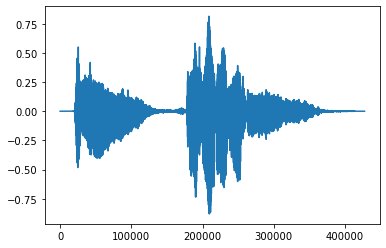

In [4]:
file = wavio.read("被遺忘的時光intro.wav")
fixed_data0 = file.data[:, 0]
fixed_data1 = file.data[:, 1]

float_data0 = fixed_data0.astype(np.float32, order='C') / 32767.0
float_data1 = fixed_data1.astype(np.float32, order='C') / 32767.0

dataSet, data0, length, iteration = PreProcessData(float_data0, frameSize, stepSize)
dataSet, data1, length, iteration = PreProcessData(float_data1, frameSize, stepSize)

plt.plot(data0)
plt.show()

IPython.display.display(IPython.display.Audio("被遺忘的時光intro.wav", rate = file.rate))

### Define Room Impulse Response Arguments
1. Speed of Sound
2. Sample Rate
3. Receive Location(Could be 2D or 3D)
4. Source Location(Could be 2D or 3D)
5. Room Size
6. Reverb Time
7. Impulse Length
8. Microphone Type
9. Reflection Order
10. Room Dimension(Could be 2D or 3D)
11. Microphone Orientation
12. Enable high-pass filer?

In [5]:
# Sound velocity (m/s)
c = 343

# Sample frequency (samples/s)
fs = 48000

# Receiver position [ x y z ] (m)
r = [1.1, 1, 1.2]

# Source position [ x y z ] (m)
s = [2, 3, 2]

# Room dimensions [ x y z ] (m)
L = [3.2, 4, 2.7]

# Absorption
beta = [-0.92] * 6

# Number of samples
nsample = frameSize

# Type of microphone
mtype = "hypercardioid"

# −1 equals maximum reflection order!
order = 10

# Room dimension
dim = 3

# Microphone orientation [azimuth elevation] in radians
orientation = [np.pi / 2]

# Enable high-pass filter
hp_filter = True

taps = RG.rir_generator(c, fs, r, s, L, beta=beta, nsample=nsample, mtype=mtype, order=order, dim=dim, orientation=orientation, hp_filter=hp_filter)

w, h = signal.freqz(taps)

amplitude = 20 * np.log10(abs(h))
angle = np.unwrap(np.angle(h))

### Time Domain Data

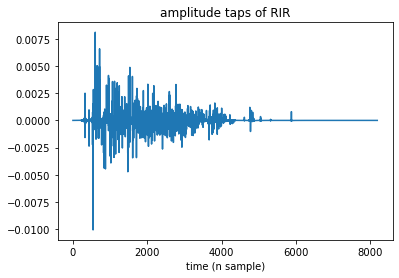

In [6]:
plt.title('amplitude taps of RIR')
plt.xlabel(r'time (n sample)')

plt.plot(taps)
plt.savefig('rir.jpg')
plt.show()

### Frequency Domain Data

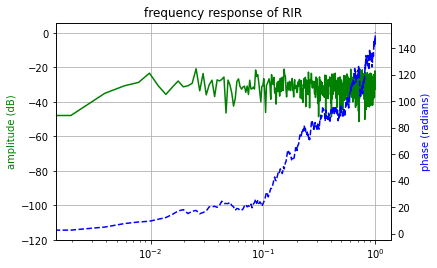

In [7]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

plt.title('frequency response of RIR')
plt.xlabel(r'normalized frequency (x$\pi$rad/sample)')

ax1.plot(w/max(w), amplitude, 'g')
ax1.set_ylabel('amplitude (dB)', color='g')
ax1.set_ylim(-120, 6)
ax1.grid()

ax2.plot(w/max(w), angle, 'b--')
ax2.set_ylabel('phase (radians)', color='b')

plt.xscale("log")
plt.show()

### Making Linear Convolution

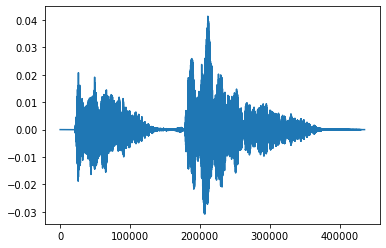

In [8]:
outputData0 = signal.convolve(taps, data0)
outputData1 = signal.convolve(taps, data1)

temp = np.array([outputData0,outputData1])

wavio.write("fir_linear_conv.wav", np.transpose(temp), file.rate, sampwidth=3)

plt.plot(outputData0)
plt.show()

IPython.display.display(IPython.display.Audio("fir_linear_conv.wav", rate=file.rate))